In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install underthesea
!pip install pandas unidecode underthesea pyvi
!pip install wordcloud matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 76.2 MB/s eta 0:00:00


## **Khai báo thư viện**

In [3]:
# Thư viện dữ liệu và xử lý số liệu
import pandas as pd
import numpy as np

# Thư viện xử lý văn bản và ngôn ngữ tự nhiên
import re # Loại bỏ kí tự đặc biệt, số
import string # Lấy danh sách số, kí tự đặc biệt
from nltk.corpus import stopwords # Lấy danh sách stopwords
from underthesea import word_tokenize # Tách từ tiếng việt

# Thư viện xử lý và biểu diễn dữ liệu
from sklearn.model_selection import train_test_split # Chia dữ liệu thành tập train, val, test
from sklearn.feature_extraction.text import TfidfVectorizer # Chuyển văn bản thành vector

# Thư viện trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns


## **Khám phá dữ liệu**

### **1. Chuẩn bị dữ liệu cho mô hình dự đoán**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/BTL_DataMining/Data_BTL/data_vnexpress_titles.csv')

# Hiển thị 5 dòng đầu tiên
display(df.head())


,Title,Category
0,'Cá mập' PYN Elite Fund: Cổ phiếu công nghệ đa...,Kinh doanh
1,"Quyết Chiến, Phương Vinh vượt qua vòng bảng bi...",Thể thao
2,"Cổ phiếu TPBank giảm mạnh, TPS nằm sàn",Kinh doanh
3,Nguyễn Thị Huyền: 'Tôi không ham hào quang sho...,Giải trí
4,9 bộ phim giúp luyện tiếng Anh từ dễ đến khó,Giáo dục


### **2. Kiểm tra kiểu dữ liệu của tất cả các cột**

In [5]:
df.info()
print('\n\033[1mKết luận:\033[0m Bộ dữ liệu có {} đặc trưng & {} mẫu.'.format(df.shape[1], df.shape[0]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     1004 non-null   object
 1   Category  1004 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB

Kết luận: Bộ dữ liệu có 2 đặc trưng & 1004 mẫu.


### **3. Tóm tắt mô tả tập dữ liệu**

In [6]:
df.describe()

,Title,Category
count,1004,1004
unique,987,6
top,Nghìn fan mặc đồ truyền thống đi xem 'Anh trai...,Kinh doanh
freq,2,170


**Nhận xét:**
- Tập dữ liệu có 1004 bài viết nhưng chỉ có 987 tiêu đề duy nhất, do đó có tiêu đề bị lặp lại
- "Kinh doanh" là thể loại phổ biến nhất với 170 bài viết

### **4. Phân tích dữ liệu**

#### **Biểu đồ thể hiện tỷ lệ và số lượng bài viết theo danh mục**

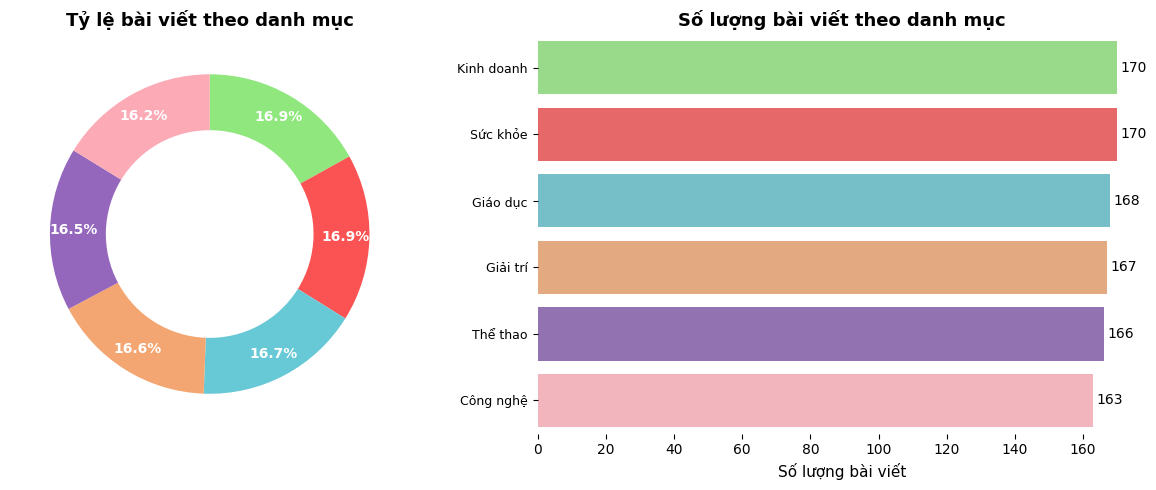

In [7]:
# Cấu hình màu nền
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Tạo figure với 2 biểu đồ
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()

# Lấy số lượng từng danh mục và sắp xếp theo thứ tự giảm dần
value_counts = df['Category'].value_counts().sort_values(ascending=np.False_)
labels = value_counts.index.tolist()

# Bảng màu cố định để đồng bộ giữa hai biểu đồ
color_palette = {
    "Giáo dục": "#68C9D6",
    "Sức khỏe": "#FB5353",
    "Kinh doanh": "#8FE77D",
    "Giải trí": "#F3A671",
    "Thể thao": "#9467bd",
    "Công nghệ": "#fcaab6",
}
colors = [color_palette[label] for label in labels]  # Áp dụng màu theo đúng thứ tự danh mục

# Biểu đồ Donut Chart
wedges, texts, autotexts = ax[0].pie(
    value_counts, autopct='%1.1f%%', textprops={'size': 10, 'color': 'white', 'fontweight': 'bold'},
    colors=colors, wedgeprops=dict(width=0.35), startangle=90, pctdistance=0.85, counterclock=False
)
# Tạo hình tròn trắng ở giữa (donut effect)
centre_circle = plt.Circle((0, 0), 0.6, fc='white')
ax[0].add_artist(centre_circle)
ax[0].set_title("Tỷ lệ bài viết theo danh mục", fontsize=13, fontweight='bold')

# Biểu đồ Count Plot
sns.countplot(data=df, y='Category', hue='Category', ax=ax[1], palette=color_palette, order=labels, legend=False)
for i, v in enumerate(value_counts):
    ax[1].text(v + 1, i, str(v), color='black', fontsize=10, va='center')

# Tinh chỉnh trục và tiêu đề
sns.despine(left=True, bottom=True)
plt.yticks(fontsize=9, color='black')
ax[1].set_ylabel(None)
ax[1].set_xlabel("Số lượng bài viết", fontsize=11)
ax[1].set_title("Số lượng bài viết theo danh mục", fontsize=13, fontweight='bold')

# Căn chỉnh layout và hiển thị
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


**Nhận xét**
- Số lượng bài viết giữa các danh mục khá đồng đều, không có danh mục nào chiếm ưu thế vượt trội.
- Kinh doanh và Sức khỏe có số lượng bài viết cao nhất (170 bài).
- Công nghệ có số lượng bài viết thấp nhất (163 bài), nhưng chênh lệch không đáng kể so với các danh mục khác.
- Tỷ lệ phần trăm giữa các danh mục không chênh lệch quá lớn, thể hiện rằng dữ liệu được phân bố khá cân bằng.

=> Đây là một bộ dữ liệu cân bằng, phù hợp cho các bài toán phân loại văn bản vì không có danh mục nào quá áp đảo.

#### **Biểu đồ histogram thể hiện phân bố độ dài tiêu đề của các bài báo**

,Title,Category,Length
0,'Cá mập' PYN Elite Fund: Cổ phiếu công nghệ đa...,Kinh doanh,66
1,"Quyết Chiến, Phương Vinh vượt qua vòng bảng bi...",Thể thao,59
2,"Cổ phiếu TPBank giảm mạnh, TPS nằm sàn",Kinh doanh,38
3,Nguyễn Thị Huyền: 'Tôi không ham hào quang sho...,Giải trí,51
4,9 bộ phim giúp luyện tiếng Anh từ dễ đến khó,Giáo dục,44


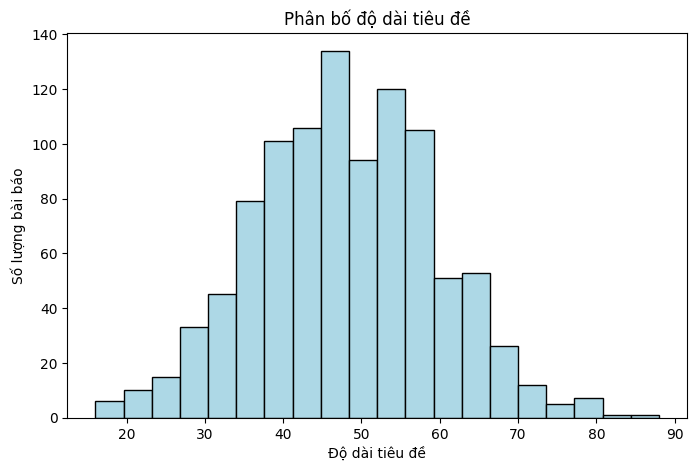

In [8]:
# Tạo cột 'Length' để lưu độ dài tiêu đề
df['Length'] = df['Title'].apply(len)
display(df.head())

plt.figure(figsize=(8, 5))
plt.hist(df['Length'], bins=20, color="lightblue", edgecolor="black") # Changed df to df['Length'] to select numerical data
plt.xlabel("Độ dài tiêu đề")
plt.ylabel("Số lượng bài báo")
plt.title("Phân bố độ dài tiêu đề")
plt.show()


**Nhận xét**
- Phần lớn tiêu đề bài báo có độ dài trong khoảng 40 - 50 ký tự, nghĩa là dữ liệu tiêu đề không quá dài hoặc quá ngắn.
- Điều này giúp ta chọn phương pháp tiền xử lý phù hợp, chẳng hạn như:
  + Nếu dùng mô hình Naive Bayes hoặc Logistic Regression, cần đảm bảo vector hóa dữ liệu (TF-IDF, BoW) hoạt động tốt với độ dài tiêu đề phổ biến.
  + Nếu dùng mô hình học sâu (Deep Learning) như RNN/LSTM, cần chuẩn hóa độ dài tiêu đề để tối ưu hiệu suất.
- Nếu độ dài tiêu đề quá ngắn, có thể thiếu thông tin quan trọng để mô hình phân loại chính xác.
- Nếu tiêu đề quá dài, có thể chứa nhiều thông tin dư thừa không cần thiết, ảnh hưởng đến hiệu quả của các phương pháp vector hóa (TF-IDF, BoW).

=> Dữ liệu tiêu đề có độ dài phân bố đều, phù hợp để sử dụng TF-IDF hoặc BoW khi huấn luyện mô hình phân loại.

#### **Biểu đồ phân tích tần suất xuất hiện từ khóa**

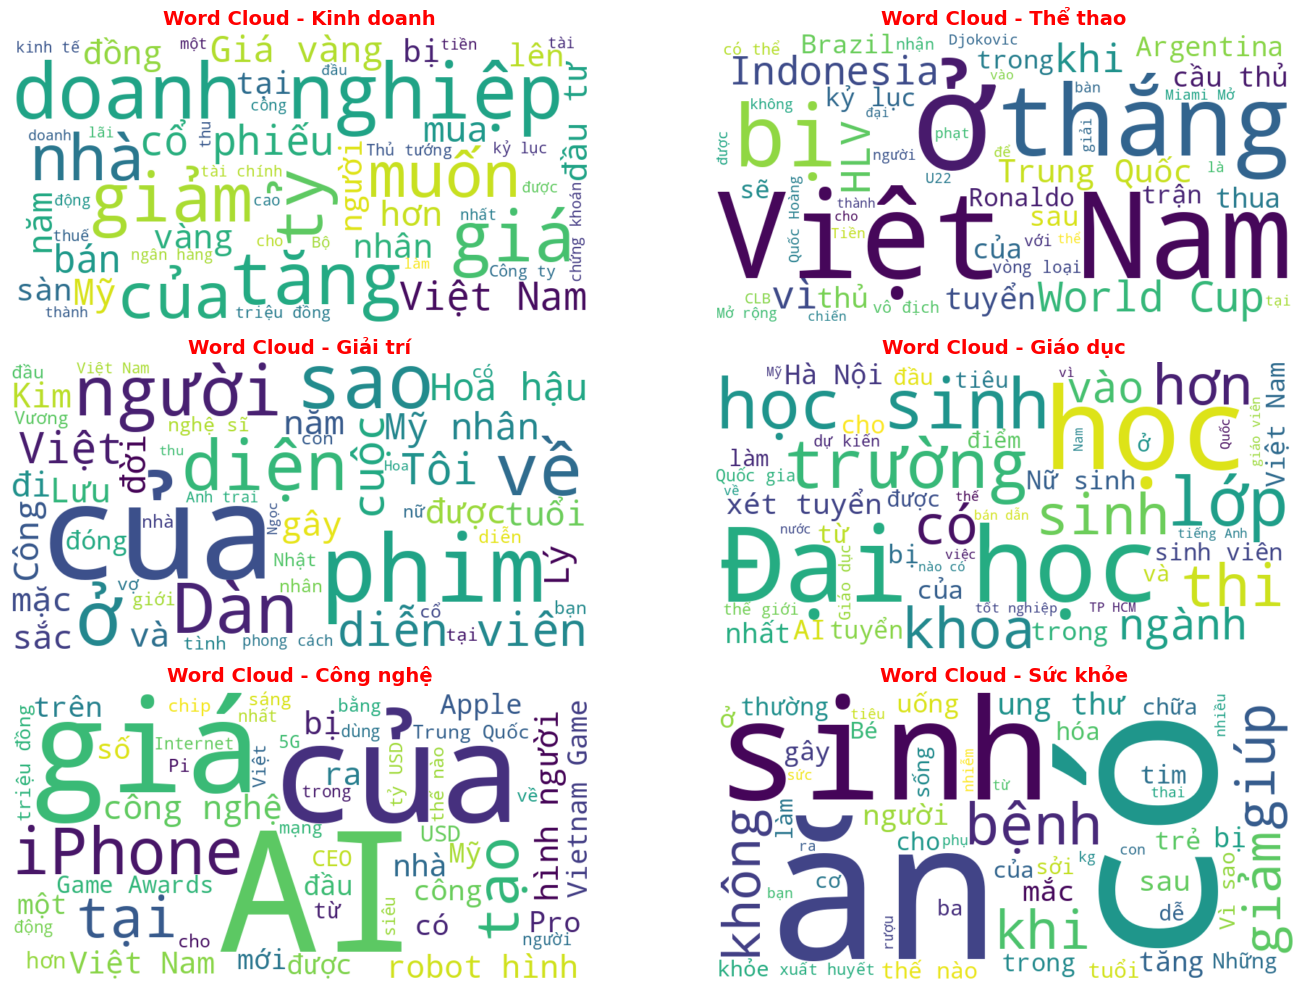

In [9]:
from wordcloud import WordCloud
# Vẽ Word Cloud riêng cho từng danh mục
categories = df['Category'].unique()

plt.figure(figsize=(15, 10))
for i, category in enumerate(categories, 1):
    # Lọc dữ liệu theo danh mục
    category_text = ' '.join(df[df['Category'] == category]['Title'])

    # Tạo Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, font_path=None).generate(category_text)

    # Vẽ Word Cloud
    plt.subplot(3, 2, i)  # Sắp xếp thành lưới 3x2 (vì có 6 danh mục)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {category.capitalize()}', fontsize=14, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

**Nhận xét:**
Từ khóa nổi bật cho từng danh mục:
* Kinh doanh: "tăng", "doanh nghiệp", "tài", "công ty", "ngân hàng".
* Thể thao: "world cup", "trận", "đội", "quốc".
* Giải trí: "phim", "ca", "ngôi sao", "vẻ".
* Giáo dục: "học", "đại học", "tuyển sinh", "giáo viên".
* Công nghệ: "ai", "công nghệ", "iphone", "game".
* Sức khỏe: "bệnh", "sức khỏe", "ung thư".

Ngoài ra còn có rất nhiều từ không mang ý nghĩa phân loại như “của”, “việt nam”, “tại”, “được”, “ở”... cần được loại bỏ để tập trung vào các từ mang ý nghĩa hơn, tăng trọng số cho các từ đặc trưng.


#### **Biểu đồ cột hiển thị tần suất của các từ phổ biến**

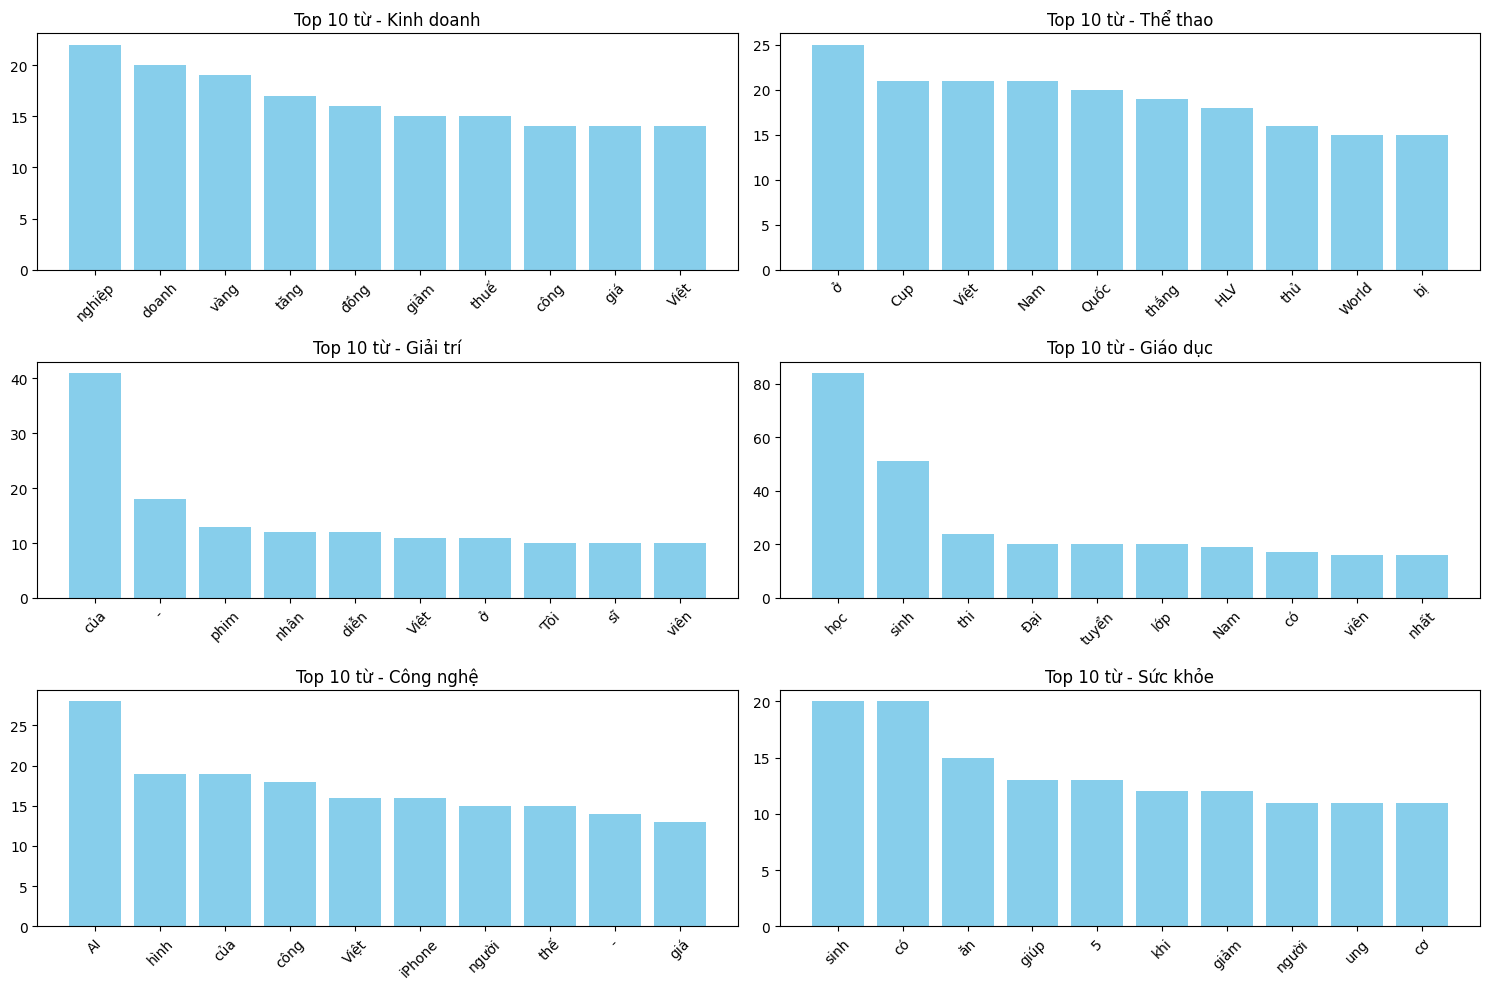

In [10]:
from collections import Counter

# Vẽ biểu đồ cột
plt.figure(figsize=(15, 10))
for i, category in enumerate(categories, 1):
    category_words = ' '.join(df[df['Category'] == category]['Title']).split()
    word_freq = Counter(category_words)
    top_words = word_freq.most_common(10)  # Lấy 10 từ phổ biến nhất

    words, freqs = zip(*top_words)
    plt.subplot(3, 2, i)
    plt.bar(words, freqs, color='skyblue')
    plt.title(f'Top 10 từ - {category.capitalize()}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

* Biểu đồ vẫn thể hiện được xu hướng chính của từng chuyên mục. Ví dụ như “AI”, “doanh nghiệp”, “phim”, “học sinh”, “bệnh”,... là những từ khóa tiêu biểu với từng chuyên mục.
* Tuy nhiên, biểu đồ xuất hiện nhiều từ không mang ý nghĩa và ký tự đặc biệt: “của”, “ở”, “.”, “5”, “-”, “có”. Những từ này không giúp phân biệt đặc trưng chuyên mục.
* Do đó ngoài những từ ngữ không mang ý nghĩa (stopwords) cần được loại bỏ thì những ký tự đặc biệt, số xuất hiện nhiều lần cũng cần được loại bỏ để tránh nhiễu trong ma trận TF-IDF, tăng độ chính xác cho các mô hình học máy.


## **Tiền xử lý dữ liệu**

### **1. Loại bỏ các giá trị trùng lặp**

In [11]:
# Xóa các hàng trùng lặp (nếu có)
counter = 0
rs, cs = df.shape  # Lưu kích thước ban đầu của DataFrame

# Tạo bản sao dữ liệu
df_cleaned = df.copy(deep=True)

df_cleaned.drop_duplicates(inplace=True)  # Xóa các hàng trùng lặp

# Kiểm tra xem kích thước của DataFrame có thay đổi hay không
if df_cleaned.shape == (rs, cs):
    print('\n\033[1mNhận xét:\033[0m Bộ dữ liệu không có bất kỳ bản sao nào')
else:
    print(f'\n\033[1mNhận xét:\033[0m Số lượng bản sao đã loại bỏ/sửa chữa ---> {rs - df_cleaned.shape[0]}')
    print('Trước khi loại bỏ các hàng trùng lặp, bộ dữ liệu có {} mẫu.'.format(df.shape[0]))
    print('Sau khi loại bỏ các hàng trùng lặp, bộ dữ liệu có {} mẫu.'.format(df_cleaned.shape[0]))



Nhận xét: Số lượng bản sao đã loại bỏ/sửa chữa ---> 17
Trước khi loại bỏ các hàng trùng lặp, bộ dữ liệu có 1004 mẫu.
Sau khi loại bỏ các hàng trùng lặp, bộ dữ liệu có 987 mẫu.


### **2. Xử lý dữ liệu**



* Kiểm tra null
* Chuyển văn bản thành chữ thường
* Loại bỏ dấu câu và ký tự đặc biệt
* Loại bỏ số
* Tách từ
* Xóa stopwords

In [12]:

def preprocess_text(text):
    if pd.isnull(text):  # Kiểm tra nếu văn bản rỗng
        return ""

    # Chuyển thành chữ thường
    text = text.lower()

    # Loại bỏ dấu câu và ký tự đặc biệt
    text = re.sub(f"[{string.punctuation}]", " ", text)

    # Loại bỏ số
    text = re.sub(r"\d+", "", text)

    # Tokenization (Tách từ)
    text_tokenized = word_tokenize(text, format="text")

    # Xóa stopwords
    stopwords = set(["là", "có", "và", "vào", "những", "được", "của", "với", "cho", "về", "tại", "trong", "ở", "đang", "đến", "qua", "vượt", "từ", "bị", "cả", "thì", "rất", "rồi", "vì", "khi", "không", "việt", "nam", "việt_nam", "sau", "hơn", "cách", "để", "bộ"])
    text_cleaned = " ".join([word for word in text_tokenized.split() if word not in stopwords])

    return text_cleaned

# Áp dụng hàm tiền xử lý cho cột 'Title'
df_cleaned["Cleaned_Title"] = df_cleaned["Title"].apply(preprocess_text)
display(df_cleaned.head())


,Title,Category,Length,Cleaned_Title
0,'Cá mập' PYN Elite Fund: Cổ phiếu công nghệ đa...,Kinh doanh,66,cá mập pyn elite fund cổ_phiếu công_nghệ định_...
1,"Quyết Chiến, Phương Vinh vượt qua vòng bảng bi...",Thể thao,59,quyết chiến_phương_vinh vòng bảng billiard châu_á
2,"Cổ phiếu TPBank giảm mạnh, TPS nằm sàn",Kinh doanh,38,cổ_phiếu tpbank giảm mạnh tps nằm sàn
3,Nguyễn Thị Huyền: 'Tôi không ham hào quang sho...,Giải trí,51,nguyễn_thị_huyền tôi ham hào_quang showbiz
4,9 bộ phim giúp luyện tiếng Anh từ dễ đến khó,Giáo dục,44,phim giúp luyện tiếng anh dễ khó


### **3. Thao tác với dữ liệu**

Vector hóa và phân chia các tập dữ liệu

In [13]:
import joblib
from sklearn.preprocessing import LabelEncoder

X = df_cleaned['Cleaned_Title']
Y = df_cleaned['Category']

# Chuyển đổi văn bản thành vector TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X_vectorized = vectorizer.fit_transform(X)

# Mã hóa nhãn thành số
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Lưu vectorizer, label_encoder
joblib.dump(vectorizer, "/content/drive/MyDrive/BTL_DataMining/Data_BTL/tfidf_vectorizer.pkl")
joblib.dump(label_encoder, "/content/drive/MyDrive/BTL_DataMining/Data_BTL/label_encoder.pkl")

# Chia dữ liệu thành các tập Train, Validation, Test
Train_X, Temp_X, Train_Y, Temp_Y = train_test_split(X_vectorized, Y_encoded, train_size=0.65, test_size=0.35, shuffle=True, random_state=100)
Validation_X, Test_X, Validation_Y, Test_Y = train_test_split(Temp_X, Temp_Y, train_size=0.5, test_size=0.5, shuffle=True, random_state=100)

# Hiển thị kích thước của các tập dữ liệu
print('Tập dữ liệu gốc  ---> ', X.shape, Y.shape)
print('Training set  ---> ', Train_X.shape, Train_Y.shape)
print('Validation set ---> ', Validation_X.shape, Validation_Y.shape)
print('Testing set   ---> ', Test_X.shape, Test_Y.shape)

#--------------Dữ liệu chia thành 6 tập--------------------------------------------------------------------------------------------------------
# Train_X,Train_Y
# Validation_X, Validation_Y
# Test_X, Test_Y
# Data trước khi chuẩn hóa tên là df
# Data sau khi chuẩn hóa tên là df_cleaned
# X lấy dữ liệu ở cột ['Cleaned_Title']
# Y lấy dữ liệu ở cột ['Category']
#------------------------------------------------------------------------------------------------------------------------------------------------

Tập dữ liệu gốc  --->  (987,) (987,)
Training set  --->  (641, 2634) (641,)
Validation set --->  (173, 2634) (173,)
Testing set   --->  (173, 2634) (173,)


**Hiển thị kết quả sau khi vector hóa dữ liệu**

In [14]:
# === In dữ liệu X và Y dưới dạng bảng ===
print("\n=== Dữ liệu sau khi vector hóa (X) và mã hóa nhãn (Y) ===")

# Chuyển ma trận X (thưa) thành dạng dày (dense) để hiển thị
X_dense = X_vectorized.toarray()

# Lấy tên các từ (features) từ vectorizer
feature_names = vectorizer.get_feature_names_out()

# Tính tổng trọng số TF-IDF của từng từ (tổng theo cột của ma trận X)
tfidf_sums = X_dense.sum(axis=0)

# Tạo danh sách các từ và trọng số tương ứng
word_weights = [(word, weight) for word, weight in zip(feature_names, tfidf_sums)]

# Sắp xếp theo trọng số giảm dần
top_words = sorted(word_weights, key=lambda x: x[1], reverse=True)[:5]
top_word_names = [word for word, weight in top_words]

# Lấy chỉ số của các từ có trọng số cao nhất
top_word_indices = [list(feature_names).index(word) for word in top_word_names]

# Tạo DataFrame từ ma trận X, lấy các cột tương ứng
X_df = pd.DataFrame(X_dense[:, top_word_indices], columns=top_word_names)

# Tạo DataFrame kết hợp Cleaned_Title, X và Y
result_df = pd.DataFrame({
    'Cleaned_Title': df_cleaned['Cleaned_Title'],
    **{col: X_df[col] for col in X_df.columns},  # Thêm các cột từ X_df
    'Category': df_cleaned['Category'],
    'Category_encoded': Y_encoded
}, index=df_cleaned.index)

# In 5 dòng đầu tiên
print("\nBảng dữ liệu (5 dòng đầu tiên):")
display(result_df.head())

# In ánh xạ của LabelEncoder dưới dạng bảng
print("\nÁnh xạ của LabelEncoder (Category → số):")
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping_df = pd.DataFrame(list(label_mapping.items()), columns=['Category', 'Encoded Value'])
print(label_mapping_df)


=== Dữ liệu sau khi vector hóa (X) và mã hóa nhãn (Y) ===

Bảng dữ liệu (5 dòng đầu tiên):


,Cleaned_Title,ai,người,giảm,đồng,giá,Category,Category_encoded
0,cá mập pyn elite fund cổ_phiếu công_nghệ định_...,0.0,0.0,0.000000,0.0,0.0,Kinh doanh,3
1,quyết chiến_phương_vinh vòng bảng billiard châu_á,0.0,0.0,0.000000,0.0,0.0,Thể thao,5
2,cổ_phiếu tpbank giảm mạnh tps nằm sàn,0.0,0.0,0.273725,0.0,0.0,Kinh doanh,3
3,nguyễn_thị_huyền tôi ham hào_quang showbiz,0.0,0.0,0.000000,0.0,0.0,Giải trí,2
4,phim giúp luyện tiếng anh dễ khó,0.0,0.0,0.000000,0.0,0.0,Giáo dục,1



Ánh xạ của LabelEncoder (Category → số):
     Category  Encoded Value
0   Công nghệ              0
1    Giáo dục              1
2    Giải trí              2
3  Kinh doanh              3
4    Sức khỏe              4
5    Thể thao              5


## **Mô hình SVM**

####**Thư viện**

In [15]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import joblib

####**Xử lý mất cân bằng dữ liệu**

In [16]:
# 1. Tính trọng số lớp
classes = np.unique(Train_Y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Train_Y)
class_weight_dict = dict(zip(classes, class_weights))

# 2. Tạo sample_weights cho từng mẫu
sample_weights = np.array([class_weight_dict[label] for label in Train_Y])

####**Tìm C tối ưu và huấn luyện mô hình**

In [17]:
# 1. Tạo đối tượng SVC để GridSearch
svc = SVC(kernel='linear', probability=True)

# 2. GridSearch để tìm C tốt nhất
param_grid_svm = {
    'C': np.logspace(-3, 2, 10)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_svm = GridSearchCV(
    svc,
    param_grid_svm,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# 3. Huấn luyện GridSearchCV với sample_weight
grid_search_svm.fit(Train_X, Train_Y, sample_weight=sample_weights)

# 4. Lấy giá trị C tốt nhất
best_c = grid_search_svm.best_params_['C']
print(f"Best C tìm được: {best_c}")

# 5. Huấn luyện lại với CalibratedClassifierCV
svm_best = SVC(kernel='linear', C=best_c)
calibrated_svm = CalibratedClassifierCV(svm_best, cv=5)
calibrated_svm.fit(Train_X, Train_Y, sample_weight=sample_weights)

# 6. Dự đoán
y_pred_svm = calibrated_svm.predict(Test_X)
print("SVM Accuracy:", accuracy_score(Test_Y, y_pred_svm))
print("\nClassification Report:\n", classification_report(Test_Y, y_pred_svm, target_names=label_encoder.classes_))

Best C tìm được: 2.1544346900318843
SVM Accuracy: 0.791907514450867

Classification Report:
               precision    recall  f1-score   support

   Công nghệ       0.70      0.79      0.74        33
    Giáo dục       0.96      0.89      0.92        27
    Giải trí       0.71      0.77      0.74        26
  Kinh doanh       0.80      0.73      0.76        33
    Sức khỏe       0.80      0.80      0.80        25
    Thể thao       0.82      0.79      0.81        29

    accuracy                           0.79       173
   macro avg       0.80      0.79      0.80       173
weighted avg       0.80      0.79      0.79       173



####**Confusion Matrix - Ma trận nhầm lẫn**

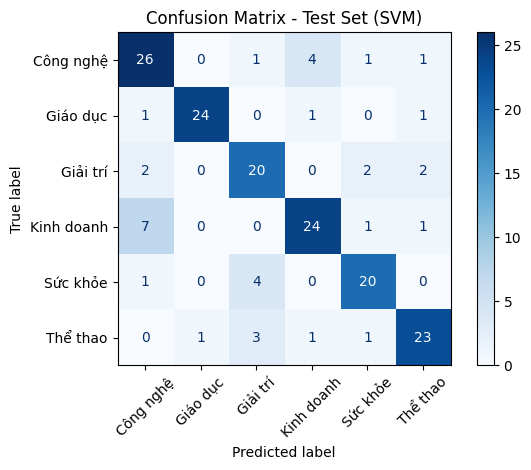

In [18]:
# Confusion Matrix
labels = np.unique(Test_Y)
cm = confusion_matrix(Test_Y, y_pred_svm, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Test Set (SVM)")
plt.tight_layout()
plt.show()

####**Dự đoán xác suất**

In [19]:
# 1. Dự đoán xác suất
y_proba_test = calibrated_svm.predict_proba(Test_X)

# 2. In xác suất dự đoán của 5 mẫu đầu tiên
print("\n Xác suất dự đoán của 5 mẫu đầu tiên:")
for i in range(5):
    true_label_original = label_encoder.inverse_transform([Test_Y[i]])[0]
    predicted_label_original = label_encoder.inverse_transform([y_pred_svm[i]])[0]

    probabilities = y_proba_test[i]
    top3_classes_idx = np.argsort(probabilities)[::-1][:3]
    top3_classes = label_encoder.inverse_transform(top3_classes_idx)

    print(f"Mẫu {i}:")
    print(f"  Nhãn thật: {Test_Y[i]} ({true_label_original})")
    print(f"  Dự đoán:    {y_pred_svm[i]} ({predicted_label_original})")
    print(f"  Xác suất:   {y_proba_test[i]}")
    for j in range(3):
        print(f"    Lớp {top3_classes[j]}: {probabilities[top3_classes_idx[j]]:.4f}")



 Xác suất dự đoán của 5 mẫu đầu tiên:
Mẫu 0:
  Nhãn thật: 0 (Công nghệ)
  Dự đoán:    0 (Công nghệ)
  Xác suất:   [0.3751617  0.03806704 0.28103359 0.22001672 0.08258262 0.00313833]
    Lớp Công nghệ: 0.3752
    Lớp Giải trí: 0.2810
    Lớp Kinh doanh: 0.2200
Mẫu 1:
  Nhãn thật: 2 (Giải trí)
  Dự đoán:    2 (Giải trí)
  Xác suất:   [0.14351125 0.01285231 0.62702165 0.03088552 0.15041788 0.03531138]
    Lớp Giải trí: 0.6270
    Lớp Sức khỏe: 0.1504
    Lớp Công nghệ: 0.1435
Mẫu 2:
  Nhãn thật: 4 (Sức khỏe)
  Dự đoán:    4 (Sức khỏe)
  Xác suất:   [0.01631441 0.0138167  0.05856764 0.28385925 0.59600567 0.03143633]
    Lớp Sức khỏe: 0.5960
    Lớp Kinh doanh: 0.2839
    Lớp Giải trí: 0.0586
Mẫu 3:
  Nhãn thật: 4 (Sức khỏe)
  Dự đoán:    4 (Sức khỏe)
  Xác suất:   [0.02582684 0.04845473 0.00231507 0.22100869 0.42315092 0.27924376]
    Lớp Sức khỏe: 0.4232
    Lớp Thể thao: 0.2792
    Lớp Kinh doanh: 0.2210
Mẫu 4:
  Nhãn thật: 0 (Công nghệ)
  Dự đoán:    0 (Công nghệ)
  Xác suất:   [0.6042

####**Hàm dự đoán nhãn**

In [20]:
# Hàm dự đoán với xác suất
def predict_category_svm(title, top_k=3):
    title_tfidf = vectorizer.transform([title])
    proba = calibrated_svm.predict_proba(title_tfidf)[0]
    top_k_indices = proba.argsort()[-top_k:][::-1]
    top_k_labels = label_encoder.inverse_transform(top_k_indices)
    top_k_probas = proba[top_k_indices]
    return list(zip(top_k_labels, top_k_probas))

####**Demo dự đoán nhãn**

In [21]:
# Giao diện người dùng
while True:
    user_input = input("Nhập tiêu đề (hoặc nhập 'q' để thoát): ")
    if user_input.lower() == 'q':
        break

    results = predict_category_svm(user_input)
    print("\nTop dự đoán:")
    for i, (label, prob) in enumerate(results, 1):
        print(f"  {i}. {label}: {prob:.4f}")

Nhập tiêu đề (hoặc nhập 'q' để thoát): q


####**Lưu mô hình**

In [22]:

# Lưu mô hình
save_dir = "/content/drive/MyDrive/BTL_DataMining/Data_BTL/"
joblib.dump(calibrated_svm, save_dir + "svm_model_calibrated.pkl")

['/content/drive/MyDrive/BTL_DataMining/Data_BTL/svm_model_calibrated.pkl']

## **Mô hình MNB**

####**Xử lý mất cân bằng dữ liệu**

In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import scipy.sparse as sp

# Lấy danh sách các lớp duy nhất trong tập huấn luyện Train_Y
classes = np.unique(Train_Y)

# 1. Tính trọng số lớp
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Train_Y)
class_weight_dict = dict(zip(classes, class_weights))

# 2. Tạo mảng trọng số tương ứng từng mẫu
sample_weights = np.array([class_weight_dict[label] for label in Train_Y])

# 3. Nhân trọng số vào từng dòng của Train_X
# Vì Train_X là sparse matrix (CSR), ta dùng sp.diags để nhân hàng-wise
Train_X_weighted = sp.diags(sample_weights) @ Train_X

####**Tìm alpha tối ưu và huấn luyện mô hình**

In [24]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Pipeline chỉ có mô hình vì dữ liệu đã vector hóa
pipe = Pipeline([
    ('clf', MultinomialNB())
])

# GridSearch trên alpha
param_grid = {
    'clf__alpha': np.linspace(0.11, 0.19, 100),  # tập trung vào khoảng tốt hơn
    'clf__fit_prior': [True, False]  # Tinh chỉnh fit_prior
}

# Sử dụng StratifiedKFold để chia lớp cân bằng hơn
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dùng GridSearchCV để tìm alpha tối ưu
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_search.fit(Train_X_weighted, Train_Y)

# Lấy alpha tốt nhất
best_alpha = grid_search.best_params_['clf__alpha']
print(f"Best alpha tìm được: {best_alpha:.4f}")

# Train lại model tốt nhất
best_mnb = MultinomialNB(alpha=best_alpha)
best_mnb.fit(Train_X_weighted, Train_Y)

# Dự đoán trên tập test
y_pred_test = best_mnb.predict(Test_X)

# Đánh giá mô hình
print("Độ chính xác trên tập Test:", accuracy_score(Test_Y, y_pred_test))
print("\nClassification Report:\n", classification_report(Test_Y, y_pred_test, target_names=label_encoder.classes_))



Best alpha tìm được: 0.1860
Độ chính xác trên tập Test: 0.7630057803468208

Classification Report:
               precision    recall  f1-score   support

   Công nghệ       0.79      0.67      0.72        33
    Giáo dục       0.71      0.89      0.79        27
    Giải trí       0.84      0.62      0.71        26
  Kinh doanh       0.80      0.73      0.76        33
    Sức khỏe       0.76      0.88      0.81        25
    Thể thao       0.73      0.83      0.77        29

    accuracy                           0.76       173
   macro avg       0.77      0.77      0.76       173
weighted avg       0.77      0.76      0.76       173



####**Confusion Matrix - Ma trận nhầm lẫn**

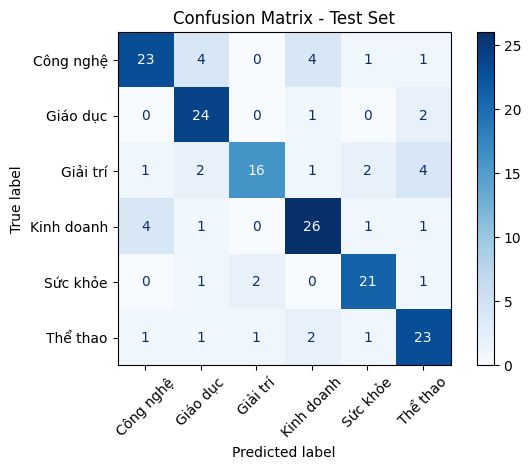

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict lại trên tập test
y_pred_test = grid_search.best_estimator_.predict(Test_X)

# Tạo confusion matrix
cm = confusion_matrix(Test_Y, y_pred_test)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

####**Dự đoán xác suất**

In [26]:
# Dự đoán xác suất với predict_proba
y_proba_test = best_mnb.predict_proba(Test_X)

# In xác suất dự đoán của 5 mẫu đầu tiên
print("\n Xác suất dự đoán của 5 mẫu đầu tiên:")
for i in range(5):
    true_label_original = label_encoder.inverse_transform([Test_Y[i]])[0]
    predicted_label_original = label_encoder.inverse_transform([y_pred_test[i]])[0]

    # Lấy xác suất dự đoán cho mẫu i
    probabilities = y_proba_test[i]

    # Lấy các chỉ số của top 3 lớp có xác suất cao nhất
    top3_classes_idx = np.argsort(probabilities)[::-1][:3]  # Sắp xếp giảm dần và lấy 3 chỉ số đầu
    top3_classes = label_encoder.inverse_transform(top3_classes_idx)  # Chuyển đổi các chỉ số thành nhãn

    print(f"Mẫu {i}:")
    print(f"  Nhãn thật: {Test_Y[i]} ({true_label_original})")
    print(f"  Dự đoán:    {y_pred_test[i]} ({predicted_label_original})")
    print(f"  Xác suất:   {y_proba_test[i]}")
    for j in range(3):
        print(f"    Lớp {top3_classes[j]}: {probabilities[top3_classes_idx[j]]:.4f}")


 Xác suất dự đoán của 5 mẫu đầu tiên:
Mẫu 0:
  Nhãn thật: 0 (Công nghệ)
  Dự đoán:    1 (Giáo dục)
  Xác suất:   [0.1981325  0.27756838 0.11128746 0.16642271 0.12950895 0.11708   ]
    Lớp Giáo dục: 0.2776
    Lớp Công nghệ: 0.1981
    Lớp Kinh doanh: 0.1664
Mẫu 1:
  Nhãn thật: 2 (Giải trí)
  Dự đoán:    2 (Giải trí)
  Xác suất:   [0.17757738 0.06782864 0.49808287 0.06173592 0.12291983 0.07185536]
    Lớp Giải trí: 0.4981
    Lớp Công nghệ: 0.1776
    Lớp Sức khỏe: 0.1229
Mẫu 2:
  Nhãn thật: 4 (Sức khỏe)
  Dự đoán:    4 (Sức khỏe)
  Xác suất:   [0.03817632 0.05215607 0.04483528 0.05786585 0.76507884 0.04188764]
    Lớp Sức khỏe: 0.7651
    Lớp Kinh doanh: 0.0579
    Lớp Giáo dục: 0.0522
Mẫu 3:
  Nhãn thật: 4 (Sức khỏe)
  Dự đoán:    4 (Sức khỏe)
  Xác suất:   [0.05045494 0.13276261 0.03358446 0.11473401 0.48426413 0.18419986]
    Lớp Sức khỏe: 0.4843
    Lớp Thể thao: 0.1842
    Lớp Giáo dục: 0.1328
Mẫu 4:
  Nhãn thật: 0 (Công nghệ)
  Dự đoán:    0 (Công nghệ)
  Xác suất:   [0.5306790

####**Hàm dự đoán nhãn**

In [27]:
def predict_category(title, top_k=3):
    title_tfidf = vectorizer.transform([title])
    proba = best_mnb.predict_proba(title_tfidf)[0]

    # Lấy top-k xác suất lớn nhất
    top_k_indices = proba.argsort()[-top_k:][::-1]
    top_k_labels = label_encoder.inverse_transform(top_k_indices)
    top_k_probas = proba[top_k_indices]

    return list(zip(top_k_labels, top_k_probas))

####**Demo dự đoán nhãn**

In [28]:
while True:
    user_input = input("Nhập tiêu đề (hoặc nhập 'e' để thoát): ")
    if user_input.lower() == 'e':
        break

    results = predict_category(user_input)

    print("\nTop dự đoán:")
    for i, (label, prob) in enumerate(results, 1):
        print(f"  {i}. {label}: {prob:.4f}")

Nhập tiêu đề (hoặc nhập 'e' để thoát): e


####**Lưu mô hình**

In [29]:
import joblib

# Lưu mô hình
# joblib.dump(mnb, 'MNB_model.pkl')
joblib.dump(best_mnb, '/content/drive/MyDrive/BTL_DataMining/Data_BTL/MNB_final_model.pkl')

['/content/drive/MyDrive/BTL_DataMining/Data_BTL/MNB_final_model.pkl']

**Dữ liệu demo (tham khảo)**

In [30]:
# Hạ HAGL, Thể Công lần thứ 3 liên tiếp vào bán kết Cup Quốc gia
# Thái Nguyên muốn dùng blockchain để phát triển kinh tế
# Yeah1 chấm dứt 'giấc mơ' thương mại điện tử tỷ USD
# Mổ ung thư giáp ở Việt Nam, sang Mỹ điều trị tiếp
# Ảnh dựng iPhone 17 mất độ tin cậy vì ChatGPT

# SO SÁNH HIỆU SUẤT GIỮA HAI MÔ HÌNH

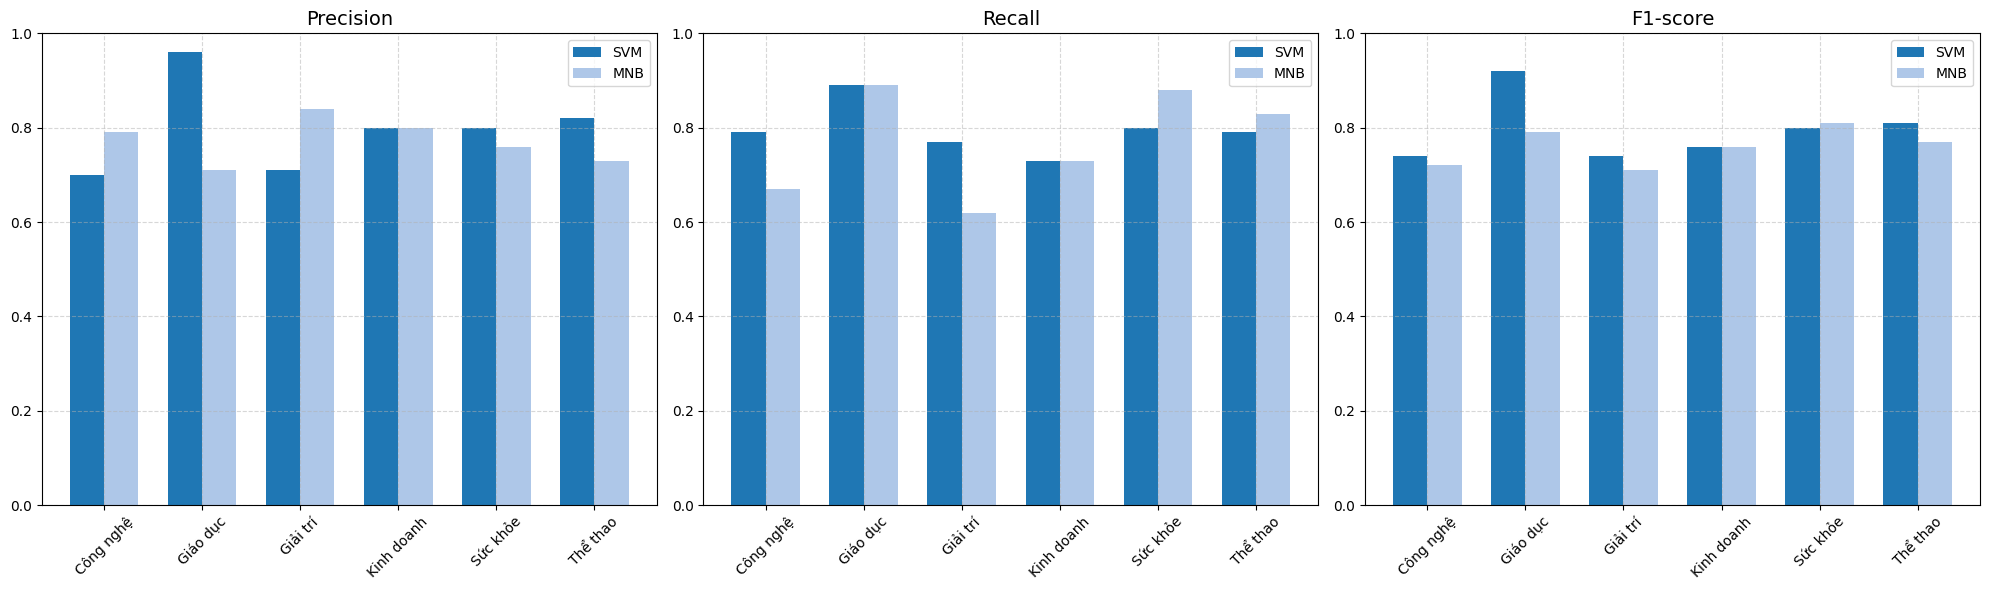

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Các nhãn
labels = ["Công nghệ", "Giáo dục", "Giải trí", "Kinh doanh", "Sức khỏe", "Thể thao"]

# Hiệu suất của từng mô hình theo từng metric
svm_scores = {
    "precision": [0.70, 0.96, 0.71, 0.80, 0.80, 0.82],
    "recall":    [0.79, 0.89, 0.77, 0.73, 0.80, 0.79],
    "f1-score":  [0.74, 0.92, 0.74, 0.76, 0.80, 0.81]
}

mnb_scores = {
    "precision": [0.79, 0.71, 0.84, 0.80, 0.76, 0.73],
    "recall":    [0.67, 0.89, 0.62, 0.73, 0.88, 0.83],
    "f1-score":  [0.72, 0.79, 0.71, 0.76, 0.81, 0.77]
}

metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(labels))  # vị trí trục x
width = 0.35  # độ rộng cột

fig, axes = plt.subplots(1, 3, figsize=(20, 6))


svm_color = "#1f77b4"      # Xanh đậm
mnb_color = "#aec7e8"      # Xanh nhạt

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(x - width/2, svm_scores[metric], width, label='SVM', color=svm_color)
    ax.bar(x + width/2, mnb_scores[metric], width, label='MNB', color=mnb_color)

    ax.set_title(metric.capitalize(), fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
